# Classification problem

The task is to predict if a sales opportunity will result in a won or a lost contract.

In [19]:
# setting logging to print only error messages of sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1. Load the data

In [4]:
url = "https://raw.githubusercontent.com/vkrit/data-science-class/master/WA_Fn-UseC_-Sales-Win-Loss.csv"
df = pd.read_csv(url)

In [5]:
df.head()

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
0,1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1,1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
2,1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
3,1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
4,1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78025 entries, 0 to 78024
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Opportunity Number                       78025 non-null  int64  
 1   Supplies Subgroup                        78025 non-null  object 
 2   Supplies Group                           78025 non-null  object 
 3   Region                                   78025 non-null  object 
 4   Route To Market                          78025 non-null  object 
 5   Elapsed Days In Sales Stage              78025 non-null  int64  
 6   Opportunity Result                       78025 non-null  object 
 7   Sales Stage Change Count                 78025 non-null  int64  
 8   Total Days Identified Through Closing    78025 non-null  int64  
 9   Total Days Identified Through Qualified  78025 non-null  int64  
 10  Opportunity Amount USD                   78025

There are 78025 rows, each describing a sales opportunity. For each sales opportunity, there are columns describing the geographical region, client size (by revenue and employee count), competitor (known, unknown, none), deal size category (how large is the potential contract), supplier group and subgroups (industry category), etc.

We are going to predict the value of "Opportunity Result" (which can be either "Win" or "Loss"), i.e. this will be our target variable.

# Step 2. Train-test split

We'll use 80% of the dataset for training and 20% for evaluation. The split will be done using stratified sampling to ensure the distributions of the "Opportunity Result" values are similar in the training and test set.

In [7]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, test_size=0.2,
                                     stratify=df["Opportunity Result"], random_state=7)

Confirm that the distribution of the variable is similar:

In [6]:
trainset["Opportunity Result"].value_counts(normalize=True)

Loss    0.774079
Won     0.225921
Name: Opportunity Result, dtype: float64

In [7]:
testset["Opportunity Result"].value_counts(normalize=True)

Loss    0.774111
Won     0.225889
Name: Opportunity Result, dtype: float64

The sizes of the two parts of the data:

In [8]:
print(f"There are {trainset.shape[0]} training and {testset.shape[0]} test instances")

There are 62420 training and 15605 test instances


# Step 3. Exploratory Data Analysis

## Distribution of numerical variables

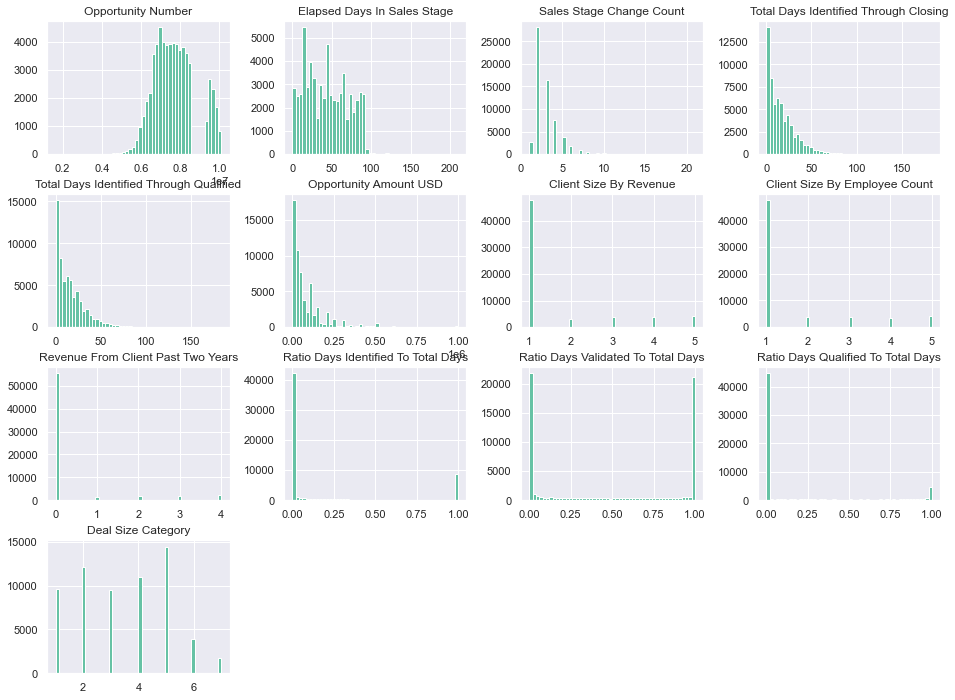

In [9]:
dummy = trainset.hist(bins=50, figsize=(16,12))

There are several variables that are right tail-heavy, suggesting they can be log-transformed.

"Opportunity number" is a row id, and should be deleted.

Several variables have to do with ratios, and the majority of their values tend to cluster around 0 and 1.

Interestingly, "Opportunity Amount USD" have a lot of values near 0. We can find out exactly how many rows there are where the opportunity amount is 0:

In [10]:
trainset[trainset["Opportunity Amount USD"] == 0].shape[0]

1641

There are quite a few of them. It may be that the opportunity amount is unknown in such cases. 

How about the "Deal Size Category" variable? The data type of "Deal Size Category" is int64, but it encodes categorical information. According to the description of the [dataset](https://books.google.co.uk/books?id=CpGyDwAAQBAJ&pg=PA409&lpg=PA409&dq=%22Sales_Win_Loss%22&source=bl&ots=5X1mrNtx8v&sig=ACfU3U1B44TUh442dz4Du9agB5K8souK5g&hl=en&sa=X&ved=2ahUKEwjP57GPsOjnAhWDmFwKHaIpCvEQ6AEwAnoECAoQAQ#v=onepage&q=%22Sales_Win_Loss%22&f=false), the integer values correspond to bands of opportunity amount, e.g., "1" stands for opportunity amounts less than 10k USD, "2" stands for opportunity amounts between 10k and 25k USD, etc. In other words, this is an ordinal variable.

If we check the number of rows that have the lowest value in this variable, it is the same as the number of rows with "Opportunity Amount USD" equal to 0:

In [11]:
trainset[(trainset["Opportunity Amount USD"] == 0) & (trainset["Deal Size Category"] == 1)].shape[0]

1641

So it may well be that the sales opportunities with unknown amounts are records also as a special category in "Deal Size Category". We may consider dropping these rows as a possible cleaning step.

Because "Deal Size Category" is ordinal, and we will use it as-is, without creating dummies.

## Distribution of categorical variables

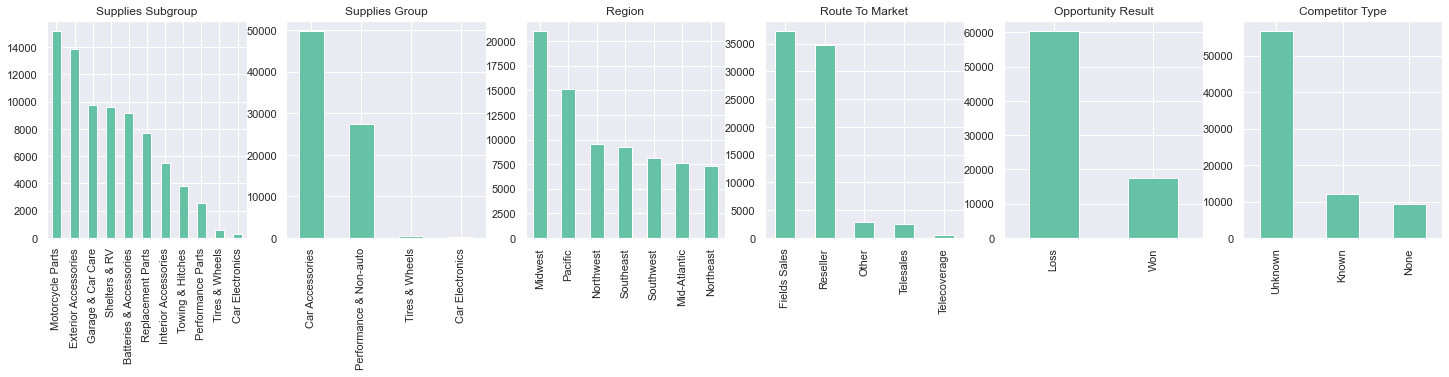

In [12]:
categorical_features = df.select_dtypes(include=['object']).columns

fig, ax = plt.subplots(1, len(categorical_features), figsize=(25, 4))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

There does not seem to be any categorical labels indicating missing values.

The "Supplies Group" and "Supplies Subgroup" encode similar information: the latter are more specific categories than the latter. Because the categorical values are more balanced with "Supplies Subgroup", we may prefer to use it and delete "Supplies Group".

# Step 4. Data cleaning and transformation

## Delete variables

In [8]:
trainset.drop(columns=["Supplies Group", "Opportunity Number"], inplace=True)
testset.drop(columns=["Supplies Group", "Opportunity Number"], inplace=True)

## Log-transform right tail-heavy variables

In [9]:
for x in ["Opportunity Amount USD", "Elapsed Days In Sales Stage", "Sales Stage Change Count",
          "Total Days Identified Through Closing", "Total Days Identified Through Qualified"]:
    # add 1 so that 0s remain 0s
    trainset[x] = np.log(trainset[x] + 1)
    testset[x] = np.log(testset[x] + 1)

## Create dummies

We'll create dummies from "Supplies Subgroup", "Region", "Route To Market", "Competitor Type".

In [10]:
from sklearn.preprocessing import OneHotEncoder


def get_dummies(trainset, testset, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    
    # the input to the encoder must be a 2-d numpy array,
    # so we take the column, extract their values and reshape the array to be 2-d
    cat_vals = trainset[old_col_name].values.reshape(-1,1)

    # fit an encoder and transform the **trainset**
    
    # the output is a new numpy array
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    # in the list of new columns, convert numpy array to a list and
    # drop the first column, because we requested "drop='first'"
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    
    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        trainset[new_col_name] = transformed[:,i]
    
    # transform the **testset** using the fitted encoder
    
    cat_vals = testset[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)

    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        testset[new_col_name] = transformed[:,i]
    
    return trainset, testset


for col_name in ["Supplies Subgroup", "Region", "Route To Market", "Competitor Type"]:
    trainset, testset = get_dummies(trainset, testset, col_name)

# check if the dummies are produced correctly in the trainset
trainset.head()

,Supplies Subgroup,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,...,Northwest,Pacific,Southeast,Southwest,Other,Reseller,Telecoverage,Telesales,None,Unknown
8279,Shelters & RV,Pacific,Fields Sales,4.262680,Loss,1.609438,3.258097,3.258097,11.542494,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16176,Shelters & RV,Northwest,Fields Sales,2.833213,Loss,1.791759,4.143135,4.143135,11.918397,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63195,Garage & Car Care,Northeast,Reseller,3.912023,Won,1.386294,2.197225,2.197225,9.014447,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12810,Motorcycle Parts,Pacific,Fields Sales,4.343805,Loss,1.098612,2.302585,2.302585,11.561725,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54035,Shelters & RV,Mid-Atlantic,Fields Sales,4.454347,Loss,1.098612,1.098612,1.098612,11.695255,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# check if the dummies are produced correctly in the testset
testset.head()

,Supplies Subgroup,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,...,Northwest,Pacific,Southeast,Southwest,Other,Reseller,Telecoverage,Telesales,None,Unknown
60315,Batteries & Accessories,Southeast,Fields Sales,3.828641,Loss,1.609438,3.091042,3.091042,11.824014,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10342,Shelters & RV,Midwest,Fields Sales,4.356709,Loss,1.098612,2.639057,2.639057,11.695255,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37888,Batteries & Accessories,Midwest,Other,3.401197,Loss,1.098612,0.693147,0.693147,11.918397,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2755,Performance Parts,Pacific,Reseller,4.510860,Loss,1.098612,3.295837,3.295837,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
53636,Exterior Accessories,Southeast,Fields Sales,4.343805,Loss,1.386294,2.564949,2.564949,12.456835,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can delete the original (i.e., categorical) columns from both the training and the test sets:

In [12]:
cols_to_drop = ["Supplies Subgroup", "Region", "Route To Market", "Competitor Type"]
trainset.drop(columns=cols_to_drop, inplace=True)
testset.drop(columns=cols_to_drop, inplace=True)

## Scale features

We fit and transform a StandardScaler

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# take the target variable out before scaling
trainset_target = trainset["Opportunity Result"].values
trainset_predictors = trainset.drop("Opportunity Result", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(trainset_predictors)
trainset = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the non-scaled target back in
trainset['Opportunity Result'] = trainset_target

# inspect the data
trainset.head()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Pacific,Southeast,Southwest,Other,Reseller,Telecoverage,Telesales,None,Unknown,Opportunity Result
0,0.834715,0.909889,0.778476,0.799311,0.535819,1.112712,-0.499072,-0.325506,0.335908,-0.830850,...,2.038657,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss
1,-0.767406,1.482327,1.532528,1.534874,0.699966,2.727300,1.983626,-0.325506,-0.418460,1.029264,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss
2,0.441705,0.209282,-0.125386,-0.082389,-0.568110,-0.501875,-0.499072,0.750549,-0.555992,-1.061819,...,-0.490519,-0.365922,-0.339735,-0.194132,1.113772,-0.089679,-0.180949,-0.366934,0.613297,Won
3,0.925639,-0.693958,-0.035619,0.005177,0.544217,1.112712,-0.499072,-0.325506,-0.555992,1.141228,...,2.038657,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,0.613297,Loss
4,1.049532,-0.693958,-1.061403,-0.995456,0.602526,-0.501875,-0.499072,-0.325506,2.185778,-1.090806,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,0.613297,Loss


Use the fitted scaler to transform also the test data:

In [14]:
testset_target = testset["Opportunity Result"].values
testset_predictors = testset.drop("Opportunity Result", axis=1)

scaled_vals = scaler.transform(testset_predictors)
testset = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the non-scaled target back in
testset['Opportunity Result'] = testset_target

testset.head()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Pacific,Southeast,Southwest,Other,Reseller,Telecoverage,Telesales,None,Unknown,Opportunity Result
0,0.348252,0.909889,0.636146,0.660471,0.658752,1.112712,1.983626,-0.325506,-0.305543,-0.865456,...,-0.490519,2.732823,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss
1,0.940101,-0.693958,0.251055,0.284822,0.602526,1.920006,-0.499072,-0.325506,-0.555992,1.141228,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,2.725282,-1.630533,Loss
2,-0.130819,-0.693958,-1.406859,-1.332442,0.699966,-0.501875,-0.499072,-0.325506,2.185778,-1.090806,...,-0.490519,-0.365922,-0.339735,5.151134,-0.897850,-0.089679,-0.180949,-0.366934,0.613297,Loss
3,1.112870,-0.693958,0.810631,0.830677,-4.504476,-0.501875,1.983626,-0.325506,-0.555992,1.141228,...,2.038657,-0.365922,-0.339735,-0.194132,1.113772,-0.089679,-0.180949,-0.366934,0.613297,Loss
4,0.925639,0.209282,0.187915,0.223230,0.935087,-0.501875,-0.499072,-0.325506,-0.293737,-1.090806,...,-0.490519,2.732823,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss


# Step 5. Train models

First, create separate arrays for the predictors (`Xtrain`) and for the target (`ytrain`):

In [20]:
from sklearn.model_selection import GridSearchCV

# drop labels for training set, but keep all others
Xtrain = trainset.drop("Opportunity Result", axis=1)

ytrain = trainset["Opportunity Result"].copy()

## Baseline

We'll use a majority class classifier as a baseline, i.e., we will find out what is the most common class label in the training set and always output it as a prediction.

In [21]:
# the number of instances belonging to each class
trainset["Opportunity Result"].value_counts()

Loss    48318
Won     14102
Name: Opportunity Result, dtype: int64

In [22]:
# total size of the training set
trainset.shape[0]

62420

The baseline classifier will output "Loss" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes).

So if we apply the baseline classifier to all of the training set. 

For the "Loss" label, the accuracy measures will be:

* Precision: 48318/62420 = 0.774

* Recall: 48318/48318 = 1.0

* F-score: 2/(1/precision + 1/recall) = 0.872

For the "Win" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/14102 = 0.0

* F-score: 0.0

The averages of the two classes, i.e. the eventual baseline scores:

* **Precision: 0.387**

* **Recall: 0.5**

* **F-score: 0.436**

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 2 x 2 = 16 combinations in the grid
param_grid = {
    'n_estimators': [10, 100, 200, 500],
    'max_depth': [5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 833.2167670726776 seconds


In [24]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       random_state=7)

In [25]:
grid_search.best_score_

0.8105791924822009

The best hyperparameters prove to be `n_estimators=200`, `max_depth=15` and `min_sample_split=5`. They achieve the F-score of **0.81**, the best so far.

Let's record the results of the best model in each split, for future reference.

The best-performing model (rank 1) is in `grid_search.cv_results_["rank_test_score"]` at index ...

In [26]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

10

We'll store the F-scores achieved by the best model in each fold, so later on we can run a t-test to compare the mean F-score with the mean scores of other methods.

In [27]:
rf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    rf_split_test_scores.append(val)

Let's review the scores achieved by all the models in the search grid:

In [28]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
10,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.891479,0.810579,9.074753
11,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 500}",0.892084,0.810563,9.138255
15,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}",0.875855,0.809872,7.533532
14,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.875850,0.809722,7.550206
9,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}",0.890960,0.809647,9.126401
13,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}",0.875559,0.809042,7.597133
8,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 10}",0.879668,0.799937,9.063829
12,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 10}",0.863356,0.796682,7.722749
3,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 500}",0.683376,0.680939,0.356536
7,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500}",0.682837,0.680024,0.411844


The performance of Random Forest classifiers varies a lot across the runs, between 0.54 and 0.81 on the validation set. In particular, we notice that better performance is achieved with greater values of `max_depth`. However, at higher values of this hyperparameter, we notice some evidence of overfitting: the performance on training parts is considerably better than on the validation part. This suggests we may gain further improvements by regularizing the model with other hyperparameters of the RF method.

In [29]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

Revenue From Client Past Two Years: 0.14694915598626623
Total Days Identified Through Qualified: 0.12733943205890508
Total Days Identified Through Closing: 0.10302804345436646
Sales Stage Change Count: 0.09001718527026302
Opportunity Amount USD: 0.08850592911217023
Elapsed Days In Sales Stage: 0.07956558720199575
Ratio Days Qualified To Total Days: 0.07665523623370608
Ratio Days Validated To Total Days: 0.05105628507766576
Ratio Days Identified To Total Days: 0.04800433985288199
Deal Size Category: 0.04151741597634323
Reseller: 0.03197238187695513
Client Size By Employee Count: 0.011901380519681915
Client Size By Revenue: 0.011894258181796876
Unknown: 0.00836791346528643
None: 0.007683682794843295
Pacific: 0.007067805637408271
Motorcycle Parts: 0.006078180965065242
Midwest: 0.0060713825827899874
Southwest: 0.0059559183890940896
Exterior Accessories: 0.005403097095110707
Garage & Car Care: 0.004971417159469702
Replacement Parts: 0.0049166747734712595
Southeast: 0.004881679657020113
Nort

Previous history of sales to the client ("Revenue From Client Past Two Years"), the size of the deal ("Opportunity Amount USD",  "Deal Size Category"), and the history of recent interaction with the client ("Elapsed Days In Sales Stage", "Sales Stage Change Count") are quite predictive of the outcome of the sales opportunity.

On the other hand, the categories of supplies and the region seem to have little to do with the outcome of the sales opportunities.

Finally, let's save the model to disk, so that if in the future we need it, e.g., after re-starting the notebook, we can read the trained model from the disk, instead of re-training it from scratch. This is useful for models that take long to train. We'll use the `dump` function from the built-in Python module `joblib` for this:

In [30]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/rf-clf.joblib')

['models/rf-clf.joblib']

If we need the model later on, we can load it with the joblib's `load` function.

## Support Vector Machines

### Linear SVMs

In [31]:
from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=5000)

# specify the hyperparameters and their values
# 5 combinations in the grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5, scoring='f1_macro', return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

C:\Users\pekarv\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the n

Took 699.8299720287323 seconds


In [32]:
grid_search.best_estimator_

LinearSVC(C=0.1, max_iter=5000, random_state=7)

In [33]:
grid_search.best_score_

0.7077948552002802

In [34]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,{'C': 0.1},0.709174,0.707795,0.194531
3,{'C': 1},0.709209,0.707706,0.212024
1,{'C': 0.01},0.709007,0.707585,0.200503
4,{'C': 10},0.708831,0.707470,0.191934
0,{'C': 0.001},0.708879,0.707341,0.216977


Fine-tuning C of the linear SVM method does not seem to produce much effect on the quality of the model.

### Radial Basis Function

<span style="color:red;font-weight:bold">Careful - the cell below may take a couple of hours to complete!</span>

In [35]:
from sklearn.svm import SVC

svm = SVC(random_state=7, kernel='rbf')

# specify the hyperparameters and their values
# 5 x 2 = 10 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ["auto", 0.1],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 31370.438645362854 seconds


Note that the non-linear SVMs take long to train and may be impractical for large datasets (over several tens of thousands of samples). When training time is an issue, one can consider [randomized grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [36]:
grid_search.best_estimator_

SVC(C=10, gamma='auto', random_state=7)

In [37]:
grid_search.best_score_

0.7924959305858236

The best model achieves an F-score of 0.792, which is only slightly worse than the best Random Forest classifier. We can check for statistical significance of the difference.

As before, let's retrieve the scores achieved by the best model on each fold.

In [38]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

6

In [39]:
# obtain the f-scores of the best models in each split

svmrbf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (at index=best_model_index) from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    svmrbf_split_test_scores.append(val)

Now we can run an independent samples t-test to compare the mean F-scores of the best RF classifier and the best RBF SVM classifier, obtained by averaging across the folds.

In [40]:
print(f"Mean F-score of RF across the folds: {np.array(rf_split_test_scores).mean()}")
print(f"Mean F-score of RBF SVM across the folds: {np.array(svmrbf_split_test_scores).mean()}")

Mean F-score of RF across the folds: 0.8105791924822009
Mean F-score of RBF SVM across the folds: 0.7924959305858236


In [41]:
# return the t-score and a two-tailed p-value
from scipy.stats import ttest_ind

ttest_ind(rf_split_test_scores, svmrbf_split_test_scores)

Ttest_indResult(statistic=7.236699504681401, pvalue=8.920033805623607e-05)

I.e., there is a significant difference between the best models produced with Random Forests and SVMs.

Let's view the scores achieved with all the SVM models in the search grid:

In [42]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
6,"{'C': 10, 'gamma': 'auto'}",0.857211,0.792496,7.549543
8,"{'C': 100, 'gamma': 'auto'}",0.913892,0.781949,14.437389
4,"{'C': 1, 'gamma': 'auto'}",0.804071,0.780950,2.875487
5,"{'C': 1, 'gamma': 0.1}",0.857588,0.773864,9.762799
7,"{'C': 10, 'gamma': 0.1}",0.940061,0.771810,17.897903
9,"{'C': 100, 'gamma': 0.1}",0.973225,0.757243,22.192409
2,"{'C': 0.1, 'gamma': 'auto'}",0.742548,0.735771,0.912674
3,"{'C': 0.1, 'gamma': 0.1}",0.693403,0.676159,2.486972
0,"{'C': 0.01, 'gamma': 'auto'}",0.576839,0.574238,0.450843
1,"{'C': 0.01, 'gamma': 0.1}",0.437147,0.437075,0.016433


Looking at the classification accuracy scores of each model, we notice that they are strongly affected by the settings for `C`: values below 0.1 result in very poor scores. High values of `C` produce better results, but notice also that at `C=100`, there is evidence of overfitting.

The most promising results are achieved with `C=10` and `gamma` set to `auto`. Further fine-tuning may focus on other settings of `C` around 10. `gamma=0.1` does not perform so well and can be dropped from further hyperparameter exploration.

Let's save the model to disk:

In [43]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/svm-rbf-clf.joblib')

['models/svm-rbf-clf.joblib']

### Polynomial SVM

<span style="color:red;font-weight:bold">Careful - the cell below may take a couple of hours to complete!</span>

In [45]:
%%script echo skipping # remove this line to run the cell

from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", gamma="scale", random_state=7, degree=2)

# specify the hyperparameters and their values
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(svm_poly, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Couldn't find program: 'echo'


In [46]:
%%script echo skipping # remove this line to run the cell

print(grid_search.best_estimator_)
print(grid_search.best_score_)

Couldn't find program: 'echo'


The selected model achieves an F-score of 0.72, which is a little better than the linear SVM, but noticeably worse than SVM with the RBF kernel.

In [47]:
%%script echo skipping # remove this line to run the cell

cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

Couldn't find program: 'echo'


The `C` hyperparameter has a lot of impact on F-score: greater values of `C` improves F-scores, althogh the rate of improvement slows down at the highest values of `C` tried.

# Step 6. Test the best models

We'll evaluate the Random Forest and the SVM with a rbf kernel on the test set.

First, load the models from disk:

In [15]:
from joblib import load

best_rf = load("models/rf-clf.joblib")
best_svm = load("models/svm-rbf-clf.joblib")

In [16]:
# drop labels for training set, but keep all others
Xtest = testset.drop("Opportunity Result", axis=1)
ytest = testset["Opportunity Result"].copy()

## Random Forest

In [17]:
from sklearn.metrics import precision_recall_fscore_support

# rf
yhat = best_rf.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.8479860701161428
Recall: 0.7903791508148983
F score: 0.8135990736025744


Plot a confusion matrix to perform error analysis:

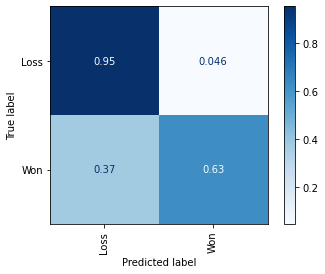

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_rf.classes_, 
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

The model accurately classifies the "Loss" class (95% of true instances of "Loss" were classified as "Loss"), but it is much less accurate classifying the "Won" instances (only 64% were classified correctly).

## SVM

In [21]:
# svm
yhat = best_svm.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.8314108113378981
Recall: 0.7822270560330655
F score: 0.8024669855702284


Thus, we find similar classification accuracy with both Random Forest and SVM classifiers, as we observed during cross-validation. Also, as was the case during cross-validation, the Random Forest performed better of the two.

Confusion matrix:

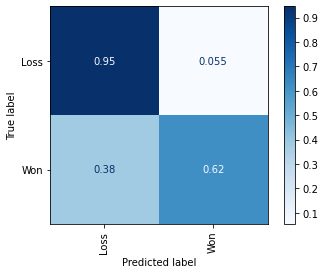

In [22]:
ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

The errors made by the SVM classifier are very similar to those made by the RF classifier.

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2022). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
